In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats

#import testing
import sys
sys.path.append("../")
import vuong_plots

In [2]:
#generate the sample
def gen_data(beta=3):
    nobs = 1000
    x = np.random.uniform(low=-3., high=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + beta * x[:,1] + e
    return y,x,nobs

yn,xn,nobs = gen_data()

In [3]:
def compute_loglike(resid):
    sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
    ll = np.log(stats.norm.pdf(resid,loc=0,scale=sigma))
    return ll

In [4]:
def compute_score(yn,xn,params):
    
    xn = sm.add_constant(xn)
    resid = yn - np.matmul(xn,params)
    
    k = len(params)
    scale = (resid**2).mean()
    
    tile_resid = np.tile( resid, k)
    tile_resid = np.reshape(tile_resid, (k,xn.shape[0]) ).transpose()
    grad = tile_resid*xn/scale     
    return grad
    
def compute_hess(yn,xn,params):
    pass


def setup_shi(yn,xn):
    x1n,x2n = xn[:,0:2],xn[:,1:3]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    k1 = len(model1_fit.params)
    
    ll1 = compute_loglike(model1_fit.resid)
    grad1 =  compute_score(yn,x1n,model1_fit.params)
    hess1 = model1.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    k2 = len(model1_fit.params)
    
    ll2 = compute_loglike(model2_fit.resid)
    grad2 =  compute_score(yn,x2n,model2_fit.params)
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

#yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

# Main examples

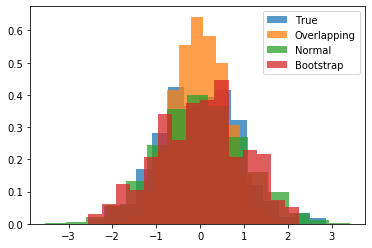

In [19]:
#generate the sample
def gen_data(beta=0):
    nobs = 500
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*x[:,2] + 1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [6]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 -0.07574305818130413
0.0 0.0026526247188324225
0.0 -0.015263044575863324
0.0 -3.547574232256296
---------
2 --------
1.0392588673559116 1.0413415504568253
0.36045709622711286 0.3605292020675263
1.0190669035621795 1.019270757713722
1.2466086868562483 1.2507779466785094
---------
3 --------
-0.14850626935075867 -0.1494014830371172
-0.011783534188288624 -0.01179060760960582
-0.010165088234839978 -0.010171190135225968
-0.2030567832072042 -0.20510325793641002
---------
4 --------
3.82940726053087 0.610670656560551
0.3533863178896292 -0.03629654179872912
3.197150462031357 0.0830205168238454
4.379801305222966 -0.25727274701330516
---------
true mean:-0.07574305818130413, eigen: -0.0048348524687753525, test_stat: -3.5463529293697134, boot_mean:-3.547574232256296


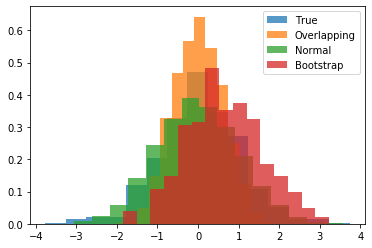

In [7]:
#generate the sample
def gen_data(beta=0):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*x[:,2] + 1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [8]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

overlap,normal = anayltic_stats

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 0.04765327437395119
0.0 0.0018446842418857379
0.0 -0.01295102241652076
0.0 0.6527822376559582
---------
2 --------
1.027837904173413 1.0298976995725582
0.35698432365236943 0.35705573479932934
1.0148047962181044 1.0150077977776601
0.867274831149571 0.8701754158691348
---------
3 --------
-0.018727940228145442 -0.01884083450852058
-8.872252439889507e-05 -8.877578276646439e-05
0.0708974688224289 0.07094002716352474
0.0903826757509336 0.0912935828329782
---------
4 --------
4.045734287512401 0.9015916620520716
0.33150512548080924 -0.050726382151722135
2.931806807477509 -0.15666318407475416
2.082107404392791 -0.16317099249038694
---------
true mean:0.04765327437395119, eigen: 0.029339595090758674, test_stat: 0.5617453234526041, boot_mean:0.6527822376559582


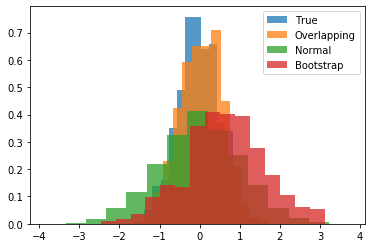

In [9]:
#generate the sample
def gen_data(beta=10):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y =  beta * x[:,1] + e
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [10]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

overlap,normal = anayltic_stats

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 -0.011553810212252234
0.0 0.044378319645635565
0.0 0.009240391826435998
0.0 0.6420345667902089
---------
2 --------
0.26861581112585553 0.2691541193645848
0.271741058296067 0.2717954173795428
1.0154885991233331 1.0156917374708274
0.966583153619606 0.969815873196929
---------
3 --------
0.004830788057396999 0.004859908629907395
-0.015089913620156256 -0.015098971795315722
0.004303537849080942 0.004306121177297674
-0.028085598606445134 -0.028368654739287735
---------
4 --------
0.19985249111552064 -0.015969167269121086
0.197183720942659 -0.02429128353633833
3.0560593683399233 -0.03640564513527514
2.8092570238225227 0.025624427619087176
---------
true mean:-0.011553810212252234, eigen: 0.23526381337290753, test_stat: 0.5489605018486206, boot_mean:0.6420345667902089


# Other examples

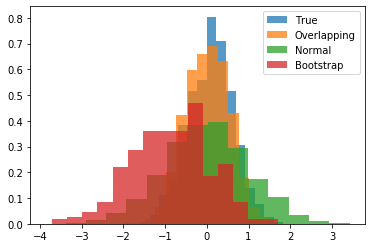

In [18]:
#generate the sample
def gen_data(beta=3):
    nobs = 500
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + .01*x[:,0] + beta * x[:,1] + e
    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [12]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

overlap,normal = anayltic_stats

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 0.06225659102370574
0.0 -0.12565571573250814
0.0 0.005532802849929997
0.0 -0.937227189898806
---------
2 --------
0.3103896156634696 0.3110116389413523
0.29988540716825274 0.2999453962475022
0.9970432162860001 0.997242664818964
1.0594234599381684 1.0629666822122092
---------
3 --------
0.017508983892740294 0.01761453015744372
0.016416218515496326 0.01642607284511758
0.03162781011566399 0.03164679566131722
0.23377889142853775 0.23613499392346315
---------
4 --------
0.3337019878370096 0.04647799469411134
0.2555251382673573 -0.014180580706008267
3.004971619331878 0.02391222949018984
3.308926394084736 -0.03668346695178994
---------
true mean:0.06225659102370574, eigen: -0.5650998811713552, test_stat: -0.6665819753626135, boot_mean:-0.937227189898806


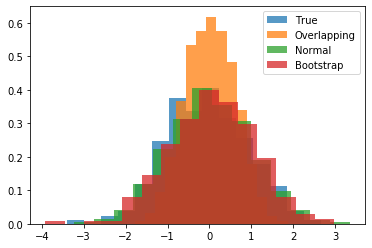

In [14]:
#generate the sample
def gen_data(beta=10):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = .1*x[:,2] + .1*x[:,0] + beta * x[:,1] + e
    return y,x,nobs


true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [15]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

overlap,normal = anayltic_stats

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 -0.0681685538256893
0.0 0.019342631700648025
0.0 0.009367882587567078
0.0 0.07616440583346301
---------
2 --------
0.9466803449055989 0.9485774999054098
0.3489942404293379 0.3490640532399859
0.9855460880742547 0.985743236721599
1.0039922180230418 1.0073500515281357
---------
3 --------
-0.030341103118090487 -0.030524002943729308
0.0016769554154796758 0.0016779620584777668
0.01036400525755578 0.01037022656387614
-0.1854789492345516 -0.18734826862595283
---------
4 --------
2.585327732180738 -0.0938575823538555
0.31903840261110844 -0.04627115610925263
2.8536103988505923 -0.05921040000027323
3.3970831090607554 0.40248622274606466
---------
true mean:-0.0681685538256893, eigen: 0.08876024501281399, test_stat: 0.09638732480373756, boot_mean:0.07616440583346301


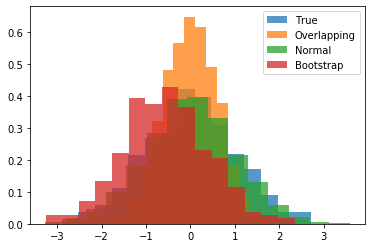

In [16]:
#generate the sample
def gen_data(beta=1):
    nobs = 1000
    #x = np.random.normal(low=-3., high=3., size=(nobs,3))
    x = np.random.normal(scale=3., size=(nobs,3))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + 2*x[:,2] + 2*x[:,0] + beta * x[:,1] + e

    return y,x,nobs

true_stats = vuong_plots.plot_true2(gen_data,setup_shi)
yn,xn,nobs = gen_data()
anayltic_stats = vuong_plots.plot_analytic2(yn,xn,nobs,setup_shi)
bootstrap_stats = vuong_plots.plot_bootstrap_pt(yn,xn,nobs,setup_shi,trials=300)

plt.legend()
plt.show()

In [17]:
overlap,normal = anayltic_stats

#print moments/kstats
for i in range(1,5):
    print('%s --------'%i)
    for distr in [true_stats,overlap,normal,bootstrap_stats]:
        m, k = stats.moment(distr, i), stats.kstat(distr, i)
        print(m,k)
    print('---------')
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
thing1 = np.array(true_stats).mean()
thing2 = vuong_plots.compute_eigen2(ll1,grad1,hess1,ll2,k1, grad2,hess2,k2).sum()

overlap,normal = anayltic_stats

sqrt_nobs = np.sqrt(yn.shape[0])
thing3 = sqrt_nobs*(ll1-ll2).mean()/ (ll1-ll2).std()
thing4 = np.array(bootstrap_stats).mean()
print('true mean:%s, eigen: %s, test_stat: %s, boot_mean:%s'%(thing1,thing2,thing3,thing4))

1 --------
0.0 0.00972550565604784
0.0 0.004551857049796897
0.0 0.007575418327497553
0.0 -0.55099566158891
---------
2 --------
1.045291928857038 1.0473867022615608
0.34102178179637327 0.34108999979633253
1.0095033087471321 1.0097052497970918
0.9393409308717852 0.9424825393362393
---------
3 --------
-0.03026230121045649 -0.030444726008700743
-0.0030961549417607885 -0.0030980135020209363
-0.032320198001915795 -0.03233959917425224
0.10070093756357504 0.10171583556734695
---------
4 --------
3.0637992136197587 -0.2038603908733812
0.30706861841134275 -0.041737824356887866
3.061820006140417 0.00575994658745052
2.681742769056666 0.0534845378749626
---------
true mean:0.00972550565604784, eigen: -0.1969756682999826, test_stat: -0.49245367775406756, boot_mean:-0.55099566158891
